## gekoppelte Pendel

In [40]:
%pylab qt5
import os

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (11, 7)

import scipy.optimize

numpy.set_printoptions(linewidth=130)

Populating the interactive namespace from numpy and matplotlib


In [41]:
tt = []
xx1 = []; xx2 = []
TT = [];
for i in range(1, 4+1):
    txt = loadtxt(f'punkte_loch{i}_schwebung.txt', skiprows=5, delimiter='\t')
    t_, x1_, x2_ = transpose(txt)
    T_ = t_[-1]
    tt.append(t_)
    xx1.append(x1_); xx2.append(x2_)
    TT.append(T_)

vals = list(zip(tt, xx1, xx2, TT))

In [42]:
# wir werten die Schwebung für das dritte Loch aus
# ändert man die 3 kann man die anderen Schwebungen auswerten
t, x1, x2, TT = vals[3 - 1]

In [43]:
print(2*pi/t[-1])

0.07095635581230476


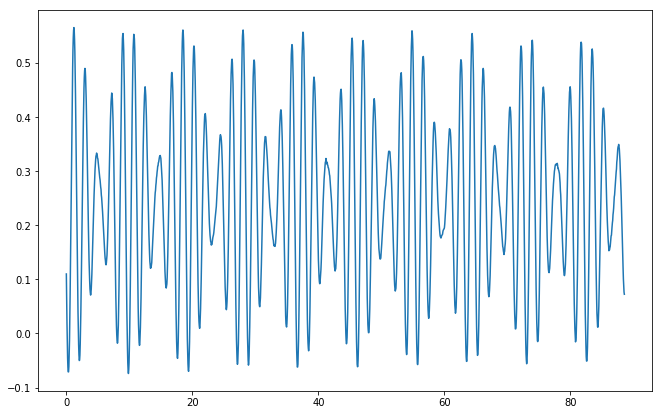

In [44]:
plt.plot(t, x1)

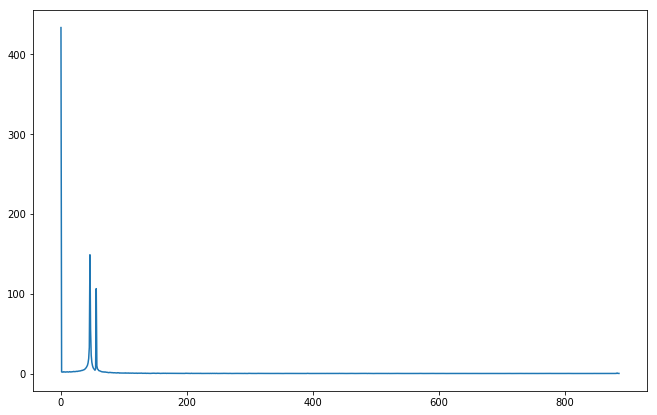

In [45]:
freq = fft.rfft(x1)
plt.plot(abs(freq))

In [46]:
n1, n2 = argpartition(-abs(freq), 2)[1:3]
print(n1, n2)

46 56


In [47]:
w1 = 2*pi/t[-1] * n1; w2 = 2*pi/t[-1] * n2
A1 = .9* sqrt(2*pi) * abs(freq[n1])/len(x1); phi1 = angle(freq[n1])
A2 = .9* sqrt(2*pi) * abs(freq[n2])/len(x1); phi2 = angle(freq[n2])

In [48]:
w1, A1, phi1
w2, A2, phi2
A = .5*(A1 + A2)

(3.263992367366019, 0.1894368720091425, 3.100083048267427)

(3.973555925489067, 0.13544176306547048, 1.8197097793998207)

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


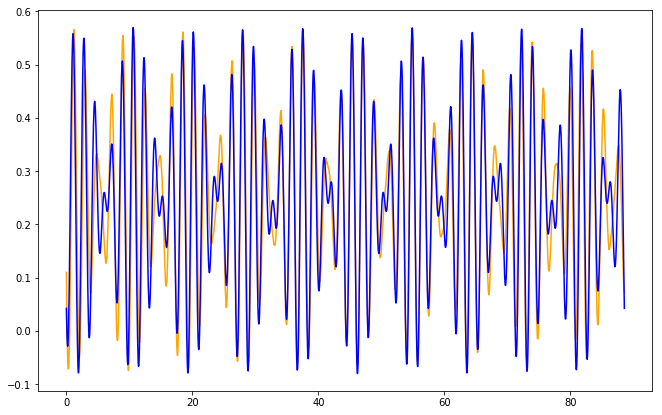

In [49]:
# _p1[0].remove(); _p2[0].remove()
_p1 = plt.plot(t, x1, 'orange')
_p2 = plt.plot(t, A * cos(w1*t + phi1) + A * cos(w2*t + phi2) + freq[0]/len(x1), 'blue')

In [50]:
2*pi/t[-1]

0.07095635581230476

In [51]:
def link(t, w1, w2, A1, A2, phi1, phi2):
    """Linearkombination von 2 Eigenmoden"""
    return A1*cos(w1*t + phi1) + A2*cos(w2*t + phi2)

def glink(t, w1, w2, A, phi1, phi2):
    """Schwebung als Linearkobination mit gleichem Koeffizient für beide Eigenmoden"""
    return A* (cos(w1*t + phi1) + cos(w2*t + phi2))

def linkd(t, w1, w2, A1, A2, phi1, phi2, g):
    """Linearkombination mit Dämpfung: exponentieller Abfall"""
    return (A1*cos(w1*t + phi1) + A2*cos(w2*t + phi2)) * exp(-g*t)

def linkd2(t, w1, w2, A1, A2, phi1, phi2, g):
    """Linearkombination mit Dämpfung: Dämpfung hängt von Geschwindigkeit ab
    (gedämpfter Oszillator)"""
    return A1*cos(w1*t + phi1)*exp(-g*w1*t) + A2*cos(w2*t + phi2)*exp(-g*w2*t)

def schweb(t, wi, wa, B, phii, phia):
    """Schwebung durch einhüllende Welle und schmelle Oszillation.
    Mathematisch äquivalent zu `glink`"""
    return B * cos(wa*t + phia) * cos(wi*t + phii)

In [52]:
a1 = x1 - mean(x1)

### fitten Schwebung direkt

In [53]:
wa = (w1 - w2)/2; wi = (w1 + w2)/2
p0 = [(w1 - w2)/2, (w1 + w2)/2, 2*A, (phi1 - phi2)/2, (phi1 + phi2)/2]
popt, pcov = scipy.optimize.curve_fit(schweb, t, a1, p0=p0,
                                      maxfev=300)

wi_, wa_, B_, phii_, phia_ = popt
err_wi, err_wa, err_B, err_phii, err_phia = sqrt(diag(pcov))
for v, err in zip(popt, sqrt(diag(pcov))):
    print(f'{v} +- {err}')
popt - p0

-0.34708479297401096 +- 0.00020332829968224515
3.6288618086280864 +- 0.00020671836518278776
0.31248823258608055 +- 0.0016383726027176854
0.2970966861744578 +- 0.010593357202232643
1.9441814158572106 +- 0.010365131052742265


array([ 0.00769699,  0.01008766, -0.0123904 , -0.34308995, -0.515715  ])

chi^2: 1.4458808197786857


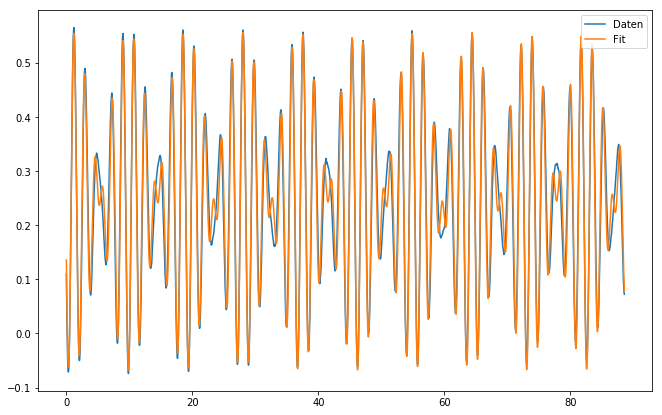

In [54]:
_ = plt.plot(t, x1)
fit = vectorize(schweb)(t, wi_, wa_, B_, phii_, phia_) + mean(x1)
_ = plt.plot(t, fit)
_ = plt.legend(['Daten', 'Fit'])
print('chi^2:', norm(x1 - fit))

### fitten Summe der Eigenmoden

In [55]:
popt, pcov = scipy.optimize.curve_fit(glink, t, a1, p0=[w1, w2, A, phi1, phi2],
                                      maxfev=200)
w1_, w2_, A_, phi1_, phi2_ = popt
err_w1, err_w2, err_A, err_phi1, err_phi2 = sqrt(diag(pcov))
for v, err in zip(popt, sqrt(diag(pcov))):
    print(f'{v} +- {err}')
popt - [w1, w2, A, phi1, phi2]

3.2817769977637377 +- 0.0002909192157501597
3.9759466353002133 +- 0.00028899079432477055
0.15624411516141928 +- 0.0008191862829023248
2.24127891514553 +- 0.014856243884364923
1.6470832569573028 +- 0.014785201755783841


array([ 0.01778463,  0.00239071, -0.0061952 , -0.85880413, -0.17262652])

chi^2: 1.445880819803296


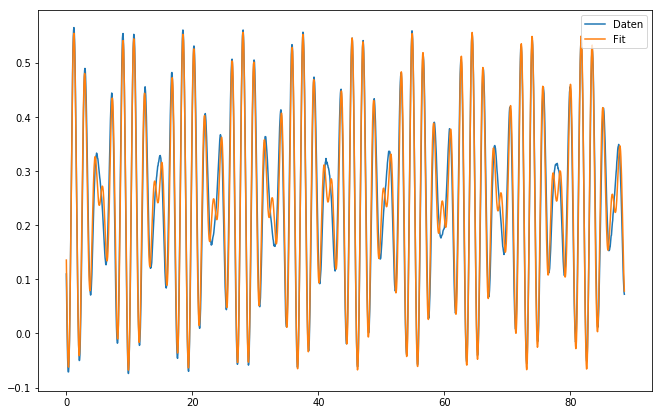

In [56]:
_ = plt.plot(t, x1)
fit = vectorize(glink)(t, w1_, w2_, A_, phi1_, phi2_) + mean(x1)
_ = plt.plot(t, vectorize(glink)(t, w1_, w2_, A_, phi1_, phi2_) + mean(x1))
_ = plt.legend(['Daten', 'Fit'])
print('chi^2:', norm(x1 - fit))

### fitten linearkombination der Eigenmoden

In [57]:
popt, pcov = scipy.optimize.curve_fit(link, t, a1, p0=[w1, w2, A1, A2, phi1, phi2],
                                      maxfev=100)
w1_, w2_, A1_, A2_, phi1_, phi2_ = popt
err_w1, err_w2, err_A1, err_A2, err_phi1, err_phi2 = sqrt(diag(pcov))
for v, err in zip(popt, sqrt(diag(pcov))):
    print(f'{v} +- {err}')
popt - [w1, w2, A1, A2, phi1, phi2]

3.2816975370777306 +- 3.0002524173494155e-05
3.975767739254149 +- 4.637870101296032e-05
0.19013886407263758 +- 0.0001448155705031674
0.12219676171559496 +- 0.00014514623898808024
2.2484548541416034 +- 0.001532235373240691
1.6594580598770445 +- 0.0023729625795670026


array([ 1.77051697e-02,  2.21181377e-03,  7.01992063e-04, -1.32450013e-02, -8.51628194e-01, -1.60251720e-01])

chi^2: 0.1814024483756481


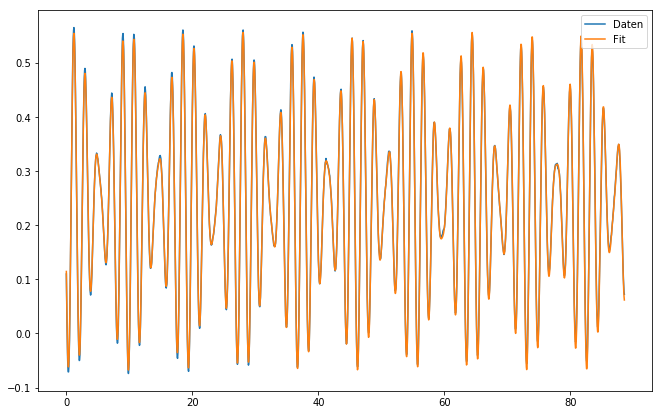

In [58]:
_ = plt.plot(t, x1)
fit = vectorize(link)(t, w1_, w2_, A1_, A2_, phi1_, phi2_) + mean(x1)
_ = plt.plot(t, fit)
_ = plt.legend(['Daten', 'Fit'])
print('chi^2:', norm(x1 - fit))

### because we can: Linearkombination mit Dämpfung

3.2817326139659 +- 1.71e-05
3.9757084489584 +- 2.65e-05
0.19743332318972 +- 0.000148
0.12678395684429 +- 0.000114
2.2466879509863 +- 0.000859
1.6624618550355 +- 0.00133
0.00087147368025293 +- 1.44e-05

Differenzen: [ 0.01774025  0.00215252  0.00799645 -0.00865781 -0.8533951  -0.15724792 -0.99912853]

chi^2: 0.10344859291694915


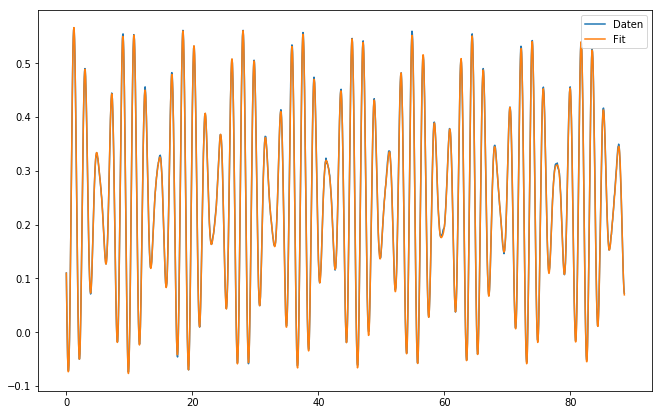

In [59]:
popt, pcov = scipy.optimize.curve_fit(linkd, t, a1, p0=[w1, w2, A1, A2, phi1, phi2, 0],
                                      maxfev=100)
w1_, w2_, A1_, A2_, phi1_, phi2_, g_ = popt
err_w1, err_w2, err_A1, err_A2, err_phi1, err_phi2, err_g = sqrt(diag(pcov))
for v, err in zip(popt, sqrt(diag(pcov))):
    print(f'{v:.14} +- {err:.3}')
print()
print('Differenzen:', popt - [w1, w2, A1, A2, phi1, phi2, 1])

_ = plt.plot(t, x1)
fit = vectorize(linkd)(t, w1_, w2_, A1_, A2_, phi1_, phi2_, g_) + mean(x1)
_ = plt.plot(t, fit)
_ = plt.legend(['Daten', 'Fit'])
print()
print('chi^2:', norm(x1 - fit))

In [60]:
pcov

array([[ 2.93850159e-10,  6.15833926e-12,  7.48624921e-11,  6.73177723e-11, -1.26751540e-08,  2.07680179e-10,  8.66339093e-12],
       [ 6.15833926e-12,  7.03502150e-10, -1.53414937e-10, -6.69885952e-11,  2.02350205e-10, -3.03722806e-08, -1.43371735e-11],
       [ 7.48624921e-11, -1.53414937e-10,  2.19163537e-08,  9.12872900e-09, -3.77951671e-09,  8.53507763e-09,  1.73795055e-09],
       [ 6.73177723e-11, -6.69885952e-11,  9.12872900e-09,  1.30905349e-08, -4.06488727e-09,  3.45691881e-09,  1.08703754e-09],
       [-1.26751540e-08,  2.02350205e-10, -3.77951671e-09, -4.06488727e-09,  7.37254965e-07, -2.79099931e-08, -4.33239209e-10],
       [ 2.07680179e-10, -3.03722806e-08,  8.53507763e-09,  3.45691881e-09, -2.79099931e-08,  1.77121898e-06,  7.27063250e-10],
       [ 8.66339093e-12, -1.43371735e-11,  1.73795055e-09,  1.08703754e-09, -4.33239209e-10,  7.27063250e-10,  2.07565966e-10]])

In [64]:
(w2_ - w1_)/2
sqrt([.5, -.5] @ pcov[0:2, 0:2] @ [.5, -.5])

0.3469879174962418

1.5692638644590298e-05

In [68]:
s = r"""• & 28.2 mm & 53.2 mm & 78.2 mm & 102.2 mm & 28.2 mm / Feder 2 \\ 
\hline 
$T_\mathrm{gl}/2$ & $\unit[(0.95841 \pm 1.1\e{-5})]{s}$ & $\unit[(0.95798 \pm 1.3\e{-5})]{s}$ & $\unit[(0.95724 \pm 3.2\e{-5})]{s}$ & $\unit[(0.95781 \pm 1.1\e{-5})]{s}$ & $\unit[(0.95826 \pm 1.3\e{-5})]{s}$ \\ 
\hline 
$T_\mathrm{geg}/2$ & $\unit[(0.92861 \pm 1.8\e{-5})]{s}$ & $\unit[(0.86739 \pm 1.1\e{-5})]{s}$ & $\unit[(0.79031 \pm 1.1\e{-5})]{s}$ & $\unit[(0.71542 \pm 1.1\e{-5})]{s}$ & $\unit[(0.91844 \pm 2.0\e{-5})]{s}$ \\ 
\hline 
$\omega_\n{S}$ berechnet & $\unit[(0.0526 \pm 0.0044)]{s^{-1}}$ & $\unit[(0.1712 \pm 0.0044)]{s^{-1}}$ & $\unit[(0.3466 \pm 0.0044)]{s^{-1}}$ & 
$\unit[(0.5556 \pm 0.0044)]{s^{-1}}$ & $\unit[(0.0711 \pm 0.0044)]{s^{-1}}$ \\ 
\hline 
$\omega_\n{S}$ experimentell & $\unit[(0.0519 \pm 0.0044)]{s^{-1}}$ & $\unit[(0.1708 \pm 0.0044)]{s^{-1}}$ & $\unit[(0.346988 \pm 16\e{-6})]{s}$ & val7 & 
$\unit[(0.0706\pm0.0044)]{s^{-1}}$"""

In [67]:
import io

In [107]:
ss = s.replace('\\\\ \n\hline', '\n').replace('•', '').replace('\n \n', '\n')

In [116]:
mockfile = io.StringIO(ss)
A = loadtxt(io.StringIO(ss), dtype=str, delimiter=' & ')

In [110]:
print(ss)

 & 28.2 mm & 53.2 mm & 78.2 mm & 102.2 mm & 28.2 mm / Feder 2 
$T_\mathrm{gl}/2$ & $\unit[(0.95841 \pm 1.1\e{-5})]{s}$ & $\unit[(0.95798 \pm 1.3\e{-5})]{s}$ & $\unit[(0.95724 \pm 3.2\e{-5})]{s}$ & $\unit[(0.95781 \pm 1.1\e{-5})]{s}$ & $\unit[(0.95826 \pm 1.3\e{-5})]{s}$ 
$T_\mathrm{geg}/2$ & $\unit[(0.92861 \pm 1.8\e{-5})]{s}$ & $\unit[(0.86739 \pm 1.1\e{-5})]{s}$ & $\unit[(0.79031 \pm 1.1\e{-5})]{s}$ & $\unit[(0.71542 \pm 1.1\e{-5})]{s}$ & $\unit[(0.91844 \pm 2.0\e{-5})]{s}$ 
$\omega_\n{S}$ berechnet & $\unit[(0.0526 \pm 0.0044)]{s^{-1}}$ & $\unit[(0.1712 \pm 0.0044)]{s^{-1}}$ & $\unit[(0.3466 \pm 0.0044)]{s^{-1}}$ & 
$\unit[(0.5556 \pm 0.0044)]{s^{-1}}$ & $\unit[(0.0711 \pm 0.0044)]{s^{-1}}$ 
$\omega_\n{S}$ experimentell & $\unit[(0.0519 \pm 0.0044)]{s^{-1}}$ & $\unit[(0.1708 \pm 0.0044)]{s^{-1}}$ & $\unit[(0.346988 \pm 16\e{-6})]{s}$ & val7 & 
$\unit[(0.0706\pm0.0044)]{s^{-1}}$


In [114]:
ss = r""" & 28.2 mm & 53.2 mm & 78.2 mm & 102.2 mm & 28.2 mm / Feder 2 
$T_\mathrm{gl}/2$ & $\unit[(0.95841 \pm 1.1\e{-5})]{s}$ & $\unit[(0.95798 \pm 1.3\e{-5})]{s}$ & $\unit[(0.95724 \pm 3.2\e{-5})]{s}$ & $\unit[(0.95781 \pm 1.1\e{-5})]{s}$ & $\unit[(0.95826 \pm 1.3\e{-5})]{s}$ 
$T_\mathrm{geg}/2$ & $\unit[(0.92861 \pm 1.8\e{-5})]{s}$ & $\unit[(0.86739 \pm 1.1\e{-5})]{s}$ & $\unit[(0.79031 \pm 1.1\e{-5})]{s}$ & $\unit[(0.71542 \pm 1.1\e{-5})]{s}$ & $\unit[(0.91844 \pm 2.0\e{-5})]{s}$ 
$\omega_\n{S}$ berechnet & $\unit[(0.0526 \pm 0.0044)]{s^{-1}}$ & $\unit[(0.1712 \pm 0.0044)]{s^{-1}}$ & $\unit[(0.3466 \pm 0.0044)]{s^{-1}}$ & $\unit[(0.5556 \pm 0.0044)]{s^{-1}}$ & $\unit[(0.0711 \pm 0.0044)]{s^{-1}}$ 
$\omega_\n{S}$ experimentell & $\unit[(0.0519 \pm 0.0044)]{s^{-1}}$ & $\unit[(0.1708 \pm 0.0044)]{s^{-1}}$ & $\unit[(0.346988 \pm 16\e{-6})]{s}$ & val7 & $\unit[(0.0706\pm0.0044)]{s^{-1}}$"""

In [127]:
transpose(A)
io2 = io.StringIO()
savetxt(io2, transpose(A), delimiter=' & ', fmt='%s')

array([['', '$T_\\mathrm{gl}/2$', '$T_\\mathrm{geg}/2$', '$\\omega_\\n{S}$ berechnet', '$\\omega_\\n{S}$ experimentell'],
       ['28.2 mm', '$\\unit[(0.95841 \\pm 1.1\\e{-5})]{s}$', '$\\unit[(0.92861 \\pm 1.8\\e{-5})]{s}$',
        '$\\unit[(0.0526 \\pm 0.0044)]{s^{-1}}$', '$\\unit[(0.0519 \\pm 0.0044)]{s^{-1}}$'],
       ['53.2 mm', '$\\unit[(0.95798 \\pm 1.3\\e{-5})]{s}$', '$\\unit[(0.86739 \\pm 1.1\\e{-5})]{s}$',
        '$\\unit[(0.1712 \\pm 0.0044)]{s^{-1}}$', '$\\unit[(0.1708 \\pm 0.0044)]{s^{-1}}$'],
       ['78.2 mm', '$\\unit[(0.95724 \\pm 3.2\\e{-5})]{s}$', '$\\unit[(0.79031 \\pm 1.1\\e{-5})]{s}$',
        '$\\unit[(0.3466 \\pm 0.0044)]{s^{-1}}$', '$\\unit[(0.346988 \\pm 16\\e{-6})]{s}$'],
       ['102.2 mm', '$\\unit[(0.95781 \\pm 1.1\\e{-5})]{s}$', '$\\unit[(0.71542 \\pm 1.1\\e{-5})]{s}$',
        '$\\unit[(0.5556 \\pm 0.0044)]{s^{-1}}$', 'val7'],
       ['28.2 mm / Feder 2 ', '$\\unit[(0.95826 \\pm 1.3\\e{-5})]{s}$ ', '$\\unit[(0.91844 \\pm 2.0\\e{-5})]{s}$ ',
        '$\

In [131]:
print(io2.getvalue().replace('\n', '\\\\\n\\hline\n'))

 & $T_\mathrm{gl}/2$ & $T_\mathrm{geg}/2$ & $\omega_\n{S}$ berechnet & $\omega_\n{S}$ experimentell\\
\hline
28.2 mm & $\unit[(0.95841 \pm 1.1\e{-5})]{s}$ & $\unit[(0.92861 \pm 1.8\e{-5})]{s}$ & $\unit[(0.0526 \pm 0.0044)]{s^{-1}}$ & $\unit[(0.0519 \pm 0.0044)]{s^{-1}}$\\
\hline
53.2 mm & $\unit[(0.95798 \pm 1.3\e{-5})]{s}$ & $\unit[(0.86739 \pm 1.1\e{-5})]{s}$ & $\unit[(0.1712 \pm 0.0044)]{s^{-1}}$ & $\unit[(0.1708 \pm 0.0044)]{s^{-1}}$\\
\hline
78.2 mm & $\unit[(0.95724 \pm 3.2\e{-5})]{s}$ & $\unit[(0.79031 \pm 1.1\e{-5})]{s}$ & $\unit[(0.3466 \pm 0.0044)]{s^{-1}}$ & $\unit[(0.346988 \pm 16\e{-6})]{s}$\\
\hline
102.2 mm & $\unit[(0.95781 \pm 1.1\e{-5})]{s}$ & $\unit[(0.71542 \pm 1.1\e{-5})]{s}$ & $\unit[(0.5556 \pm 0.0044)]{s^{-1}}$ & val7\\
\hline
28.2 mm / Feder 2  & $\unit[(0.95826 \pm 1.3\e{-5})]{s}$  & $\unit[(0.91844 \pm 2.0\e{-5})]{s}$  & $\unit[(0.0711 \pm 0.0044)]{s^{-1}}$  & $\unit[(0.0706\pm0.0044)]{s^{-1}}$\\
\hline



In [120]:
io2.write(' ')

1

In [122]:
io2.getvalue()

' '